# TP 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle, islice
import datetime as datetime
import glob
from matplotlib import pyplot
from IPython.display import Image
import plotly.express as px
import pycountry
import geopandas as gpd
import difflib
#import psutil

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

plt.rcParams['figure.figsize'] = (15, 5)

import warnings
warnings.filterwarnings('ignore')

In [2]:
eci = pd.read_csv('Entrenamieto_ECI_2020.csv')

# Preprocesamiento y limpieza de datos

Completo los datos faltantes de 'Total_Taxable_Amount' con los de 'Total_Amount'

In [ ]:
len(eci['Total_Taxable_Amount'].loc[eci.Total_Taxable_Amount==0.00])

In [3]:
eci['Total_Taxable_Amount'].loc[eci.Total_Taxable_Amount==0.00] = eci.loc[eci.Total_Taxable_Amount==0.00]\
                                            .groupby(['Opportunity_Name'])['Total_Amount'].transform('sum')

Vemos que van a quedar pocos valores que tienen 'Total_Taxable_Amount' y 'Total_Amount' en cero. Llegado el caso de estudio, se pueden ignorar

In [ ]:
len(eci['Total_Taxable_Amount'].loc[eci.Total_Taxable_Amount==0.00])

In [ ]:
eci.loc[eci.Total_Taxable_Amount==0.00]['Total_Amount'].value_counts()

In [ ]:
eci.loc[eci.Total_Taxable_Amount==0.00]['Total_Amount'].isnull().sum()

Convierto Total_Amount y Total_Taxable_Amount a una sola moneda

In [ ]:
#Para convertir todos los precios de Total_Amount de diferentes monedas a dolar, no voy a usar los precios del
#mercado actual. Voy a utilizar la conversión que se usó en el dataset original en la columna ASP_(converted)

In [4]:
toEUR = eci[eci.ASP_Currency=='EUR'].head(1)[['ASP_(converted)']].iloc[0,0]/eci[eci.ASP_Currency=='EUR'].head(1)[['ASP']].iloc[0,0]
toAUD = eci[eci.ASP_Currency=='AUD'].head(1)[['ASP_(converted)']].iloc[0,0]/eci[eci.ASP_Currency=='AUD'].head(1)[['ASP']].iloc[0,0]
toGBP = eci[eci.ASP_Currency=='GBP'].head(1)[['ASP_(converted)']].iloc[0,0]/eci[eci.ASP_Currency=='GBP'].head(1)[['ASP']].iloc[0,0]
toJPY = eci[['ASP_(converted)']].iloc[12,0]/eci[['ASP']].iloc[12,0]
#En el head(1) de JPY justo habia un nan. Ese numero magico 12 corresponde a la primera fila de moneda JPY con un valor valido

In [ ]:
#Lo siguiente es para comprobar que funciona bien

In [ ]:
eci['ASP_(convertido)']=0.0
eci['ASP_(convertido)'].loc[eci.ASP_Currency=='EUR'] = eci['ASP'].apply(lambda x: x*toEUR)
eci['ASP_(convertido)'].loc[eci.ASP_Currency=='JPY'] = eci['ASP'].apply(lambda x: x*toJPY)
eci['ASP_(convertido)'].loc[eci.ASP_Currency=='AUD'] = eci['ASP'].apply(lambda x: x*toAUD)
eci['ASP_(convertido)'].loc[eci.ASP_Currency=='GBP'] = eci['ASP'].apply(lambda x: x*toGBP)
eci['ASP_(convertido)'].loc[eci.ASP_Currency=='USD'] = eci['ASP'].apply(lambda x: x)

In [ ]:
eciAux = eci.dropna(subset=['ASP_(converted)'])

In [ ]:
print("Coinciden todos en el subset: ", all(abs(eciAux['ASP_(converted)']-eciAux['ASP_(convertido)']) < 0.01))

In [ ]:
del eciAux
eci.drop(columns='ASP_(convertido)',inplace=True)

In [5]:
#Ahora si hago la conversion
eci['Total_Amount_(converted)']=0.0
eci['Total_Amount_(converted)'].loc[eci['Total_Amount_Currency']=='EUR'] = eci['Total_Amount'].apply(lambda x: x*toEUR)
eci['Total_Amount_(converted)'].loc[eci['Total_Amount_Currency']=='JPY'] = eci['Total_Amount'].apply(lambda x: x*toJPY)
eci['Total_Amount_(converted)'].loc[eci['Total_Amount_Currency']=='AUD'] = eci['Total_Amount'].apply(lambda x: x*toAUD)
eci['Total_Amount_(converted)'].loc[eci['Total_Amount_Currency']=='GBP'] = eci['Total_Amount'].apply(lambda x: x*toGBP)
eci['Total_Amount_(converted)'].loc[eci['Total_Amount_Currency']=='USD'] = eci['Total_Amount'].apply(lambda x: x)

eci['Total_Taxable_Amount_(converted)']=0.0
eci['Total_Taxable_Amount_(converted)'].loc[eci['Total_Taxable_Amount_Currency']=='EUR'] = eci['Total_Taxable_Amount'].apply(lambda x: x*toEUR)
eci['Total_Taxable_Amount_(converted)'].loc[eci['Total_Taxable_Amount_Currency']=='JPY'] = eci['Total_Taxable_Amount'].apply(lambda x: x*toJPY)
eci['Total_Taxable_Amount_(converted)'].loc[eci['Total_Taxable_Amount_Currency']=='AUD'] = eci['Total_Taxable_Amount'].apply(lambda x: x*toAUD)
eci['Total_Taxable_Amount_(converted)'].loc[eci['Total_Taxable_Amount_Currency']=='GBP'] = eci['Total_Taxable_Amount'].apply(lambda x: x*toGBP)
eci['Total_Taxable_Amount_(converted)'].loc[eci['Total_Taxable_Amount_Currency']=='USD'] = eci['Total_Taxable_Amount'].apply(lambda x: x)

In [6]:
#Nuevas columnas que voy a usar después
eci['Cantidad_de_Productos_por_Oportunidad'] = eci.groupby('Opportunity_ID')['ID'].transform('count')
eci['TRF_totales'] = eci.groupby('Opportunity_ID')['TRF'].transform('sum')
eci['TRF_promedioDeLaOportunidad'] = eci.groupby('Opportunity_ID')['TRF'].transform('mean')

In [7]:
eci['Planned_Delivery_End_Date']=pd.to_datetime(eci['Planned_Delivery_End_Date'])
eci['Planned_Delivery_Start_Date']=pd.to_datetime(eci['Planned_Delivery_Start_Date'])

In [8]:
eciOp = eci.drop_duplicates('Opportunity_ID')

In [9]:
eciWon = eciOp[(eciOp.Stage=='Closed Won')|(eciOp.Stage=='Closed Lost')]
eciWon['ganada'] = eciWon['Stage'].apply(lambda x: 1 if x=='Closed Won' else 0)

In [ ]:
#Columna inservible
eci['Actual_Delivery_Date'].value_counts()

In [ ]:
#Columna inservible
eci['Last_Activity'].value_counts()

In [ ]:
#Columna inservible
eci['Submitted_for_Approval'].value_counts()

In [ ]:
#Columna poco importante
eci['Prod_Category_A'].value_counts()

In [ ]:
#Todo es en dolares
eci['ASP_(converted)_Currency'].value_counts()

COLUMNAS CON MUCHISIMOS VALORES NULOS: Brand, Product_Type, Size, Product_Category_B, Price, Currency

# 3. Analisis general

In [10]:
region = eciOp['Region'].value_counts().to_frame().reset_index()\
                        .rename(columns={'index':'Region','Region':'cantidad'})
region

,Region,cantidad
0,EMEA,3241
1,Americas,2459
2,APAC,2086
3,Japan,1906
4,Middle East,149


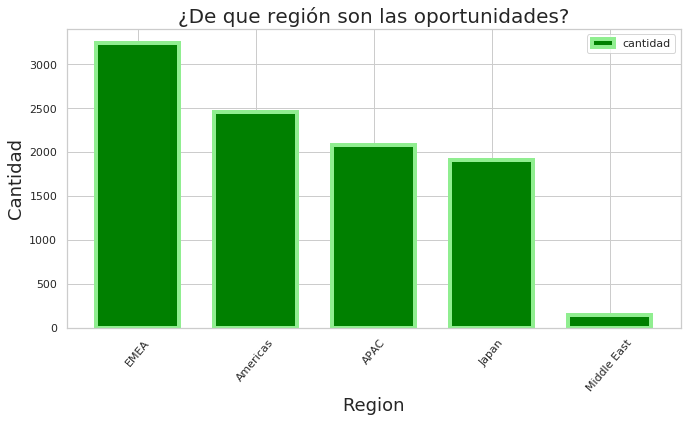

In [11]:
region.plot(kind='bar', x='Region', y='cantidad',\
                 width=0.7, figsize=(11,5.5), color='green',\
                 edgecolor="lightgreen", linewidth=4, rot=50)
g=plt.gca()
g.set_title("¿De que región son las oportunidades?",\
            fontsize=20);
g.set_xlabel("Region", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

---------------------------------------------------

In [12]:
territory = eciOp['Territory'].value_counts().to_frame().reset_index()\
                              .rename(columns={'index':'Territorio','Territory':'Cantidad'})
territory = territory[territory['Territorio']!='None']
territory

,Territorio,Cantidad
1,Germany,1080
2,NW America,878
3,India,680
4,Japan,607
5,Australia,579
...,...,...
71,Armenia,1
72,Monaco,1
73,Solomon Islands,1
74,Burma,1


In [13]:
def cambiar_nombre(nombre):
    switcher = {
        'China (PRC)': 'China',
        'South Korea': 'Korea, Republic of',
        'KSA': 'Saudi Arabia',
        'Vietnam': 'Viet Nam',
        'Taiwan': 'Taiwan, Province of China',
        'UAE (Dubai)': 'United Arab Emirates',
        'NW America': 'United States',
        'Central US': 'United States',
        'SE America': 'United States',
        'NE America': 'United States',
        'SW America': 'United States',
        'Macedonia': 'North Macedonia',
        'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
        'Czech Republic': 'Czechia',
        'Burma': 'Myanmar',
        'Palestine': 'Palestine, State of',
        'Macedonia, the former Yugoslav Republic of': 'North Macedonia'
    }
    return switcher.get(nombre,nombre)

In [14]:
territory['Territorio'] = territory['Territorio'].apply(lambda x: cambiar_nombre(x))

In [15]:
def get_alpha_3(location):
    try:
        return pycountry.countries.get(name=location).alpha_3
    except:
        return 'Desconocido'

In [16]:
territory['Code'] = territory['Territorio'].apply(lambda x: get_alpha_3(x))

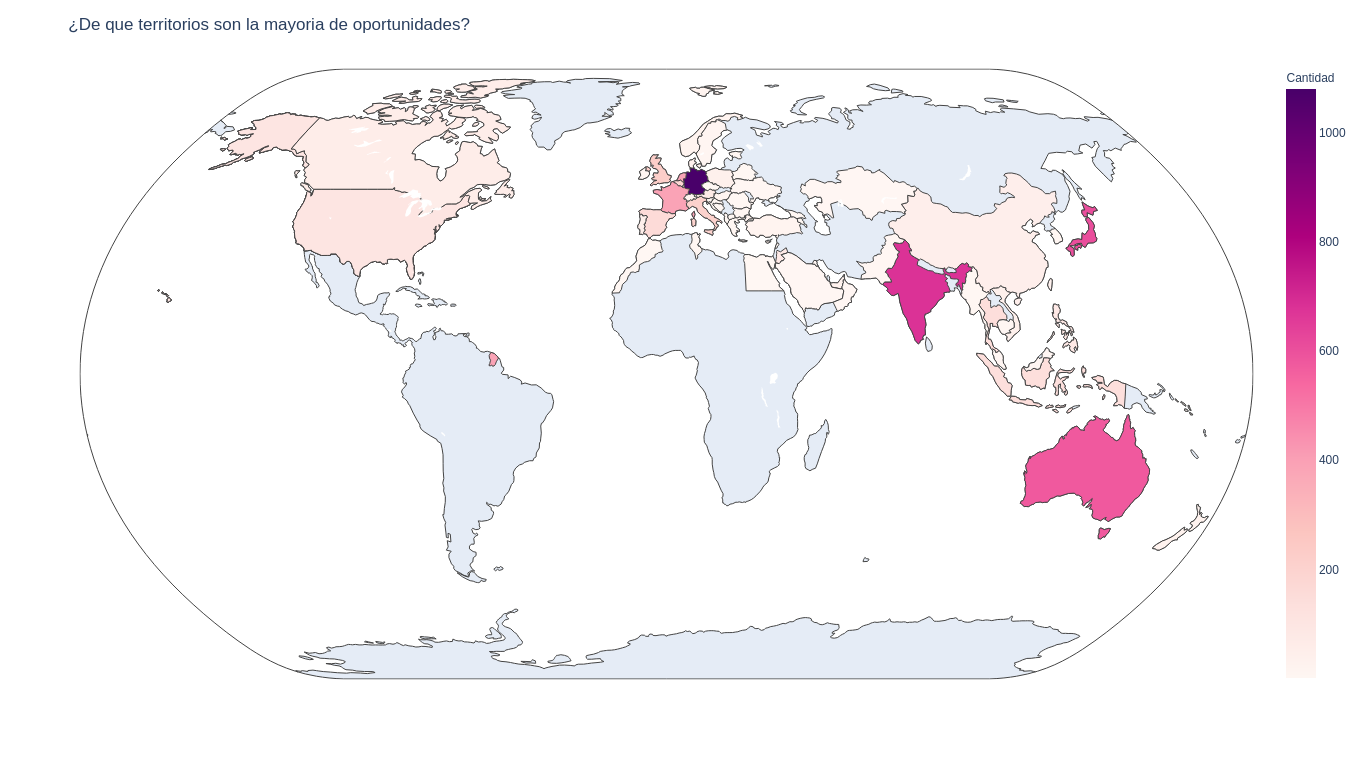

In [17]:
fig = px.choropleth(territory,locations='Code',color='Cantidad',\
                    color_continuous_scale=px.colors.sequential.RdPu,hover_name='Territorio',)
fig.update_layout(
    title_text = '¿De que territorios son la mayoria de oportunidades?'
)
fig.update_geos(projection_type="natural earth")
#fig.show()
fig.write_image("territorio.png",width=1366,height= 768)
Image("territorio.png")

--------

In [18]:
billingCountry = eciOp['Billing_Country'].value_counts().to_frame().reset_index()\
                                         .rename(columns={'index':'Pais','Billing_Country':'Cantidad'})
billingCountry 

,Pais,Cantidad
0,United States,2350
1,Japan,1899
2,Germany,1308
3,India,560
4,Australia,559
...,...,...
75,Libya,1
76,Argentina,1
77,Belize,1
78,Colombia,1


In [19]:
billingCountry ['Pais'] = billingCountry ['Pais'].apply(lambda x: cambiar_nombre(x))
billingCountry['Code'] = billingCountry['Pais'].apply(lambda x: get_alpha_3(x))

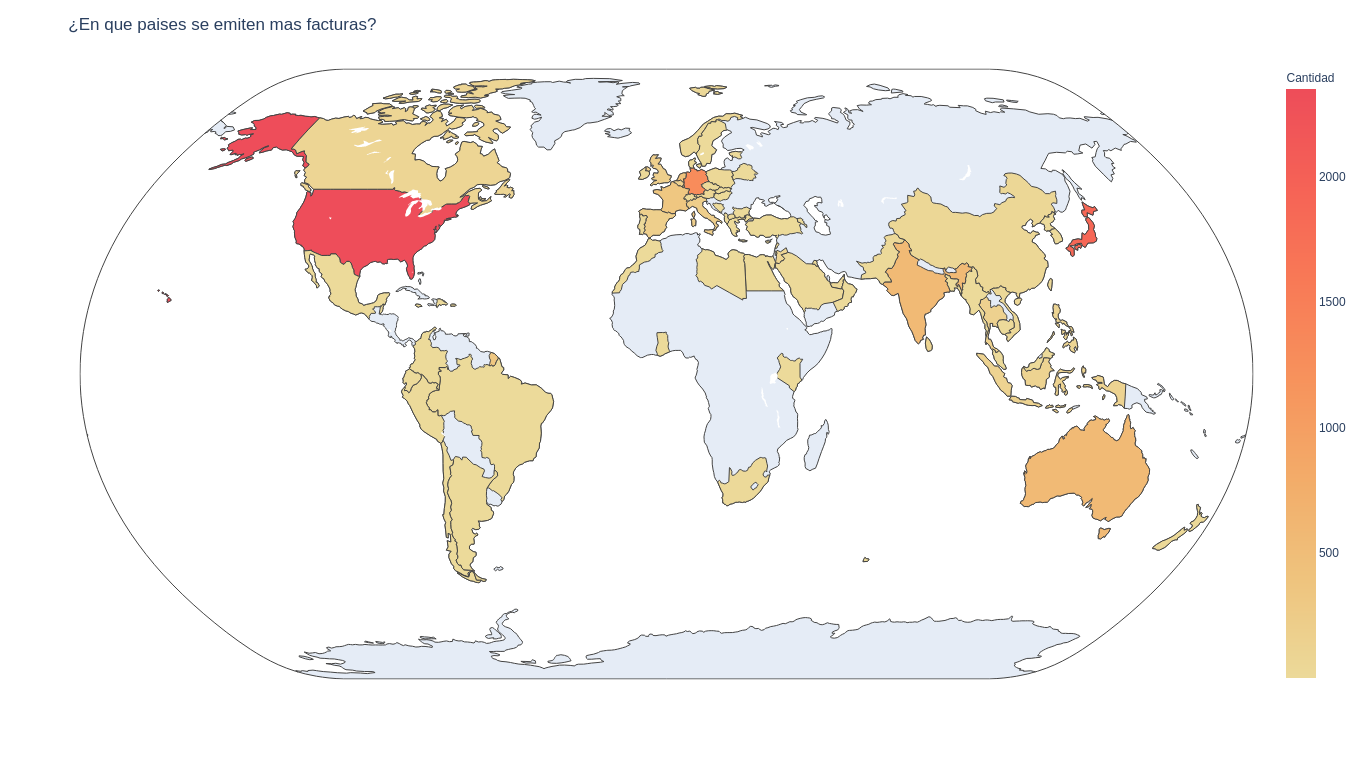

In [20]:
fig = px.choropleth(billingCountry,locations='Code',color='Cantidad',\
                    color_continuous_scale=px.colors.sequential.Oryel,hover_name='Pais',)
fig.update_layout(
    title_text = '¿En que paises se emiten mas facturas?'
)
fig.update_geos(projection_type="natural earth")
#fig.show()
fig.write_image("billing.png",width=1366,height= 768)
Image("billing.png")

-------------

In [21]:
eciOp['Account_Created_Date'] = pd.to_datetime(eciOp['Account_Created_Date'])
eciOp['Account_Created_Year'] = eciOp['Account_Created_Date'].dt.year
accountCreatedYear = eciOp.groupby('Account_Created_Year').agg({'ID':'count'}).reset_index().rename(columns={'ID':'cantidad','Account_Created_Year':'Año'})
accountCreatedYear

,Año,cantidad
0,2013,2835
1,2014,885
2,2015,1898
3,2016,2137
4,2017,1526
5,2018,560


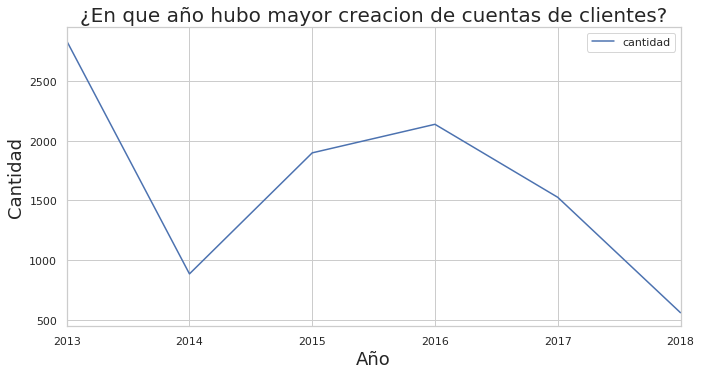

In [22]:
accountCreatedYear.plot(kind='line', x='Año', y='cantidad',figsize=(11,5.5))
g=plt.gca()
g.set_title("¿En que año hubo mayor creacion de cuentas de clientes?",\
            fontsize=20);
g.set_xlabel("Año", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

------------

In [23]:
eci['Opportunity_Created_Date'] = pd.to_datetime(eci['Opportunity_Created_Date'])
eci['Opportunity_Created_Year'] = eci['Opportunity_Created_Date'].dt.year
opportunityCreatedYear = eci.groupby('Opportunity_Created_Year').agg({'ID':'count'}).reset_index().rename(columns={'ID':'cantidad','Opportunity_Created_Year':'Año'})
opportunityCreatedYear

,Año,cantidad
0,2013,1
1,2014,40
2,2015,1012
3,2016,4355
4,2017,6921
5,2018,4618


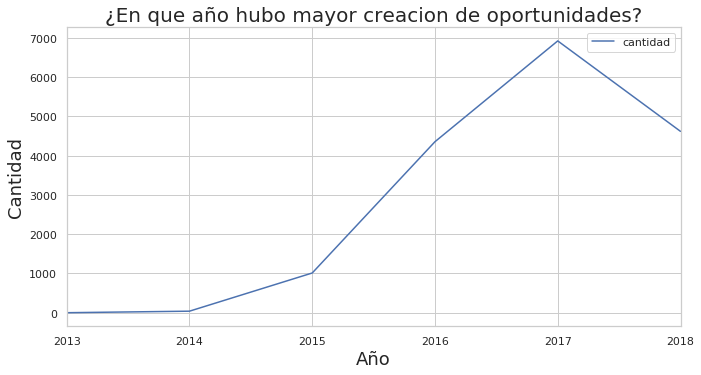

In [24]:
opportunityCreatedYear.plot(kind='line', x='Año', y='cantidad',figsize=(11,5.5))
g=plt.gca()
g.set_title("¿En que año hubo mayor creacion de oportunidades?",\
            fontsize=20);
g.set_xlabel("Año", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

---

In [25]:
# number of variable
categories = list(eciOp.groupby('Delivery_Year').count().index)
#categories = [2016,2017,2018,2019,2020]
print(categories)

[2016, 2017, 2018, 2019, 2020]


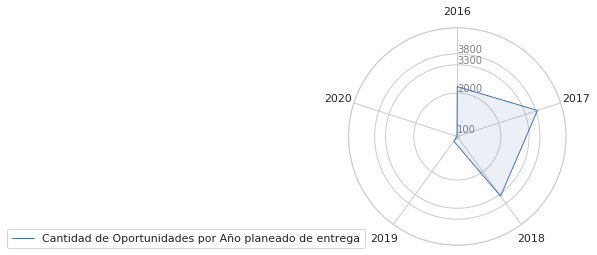

In [26]:
# number of variable
N = len(categories)
    
    
from math import pi
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)


# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([3800,3300,2000, 100], ["3800","3300","2000","100","5000"], color="grey", size=10)
plt.ylim(0,5000)

values2 = list(eciOp.groupby('Delivery_Year')['Opportunity_ID'].count())
values2 += values2[:1]

ax.plot(angles, values2, linewidth=1, linestyle='solid', label="Cantidad de Oportunidades por Año planeado de entrega")
ax.fill(angles, values2, 'b', alpha=0.1)


plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

---

In [27]:
opportunities = eciOp
opportunities['Planned_Delivery_End_Date'].fillna(np.NaN).dropna()

0       2016-06-30
1       2016-01-20
2       2016-01-25
3       2018-03-31
4       2018-02-28
           ...    
16939   2016-04-21
16940   2016-12-30
16942   2016-03-25
16945   2016-04-29
16946   2016-08-31
Name: Planned_Delivery_End_Date, Length: 9771, dtype: datetime64[ns]

In [28]:
opportunities['Planned_Delivery_End_Date_Month'] = opportunities['Planned_Delivery_End_Date'].dt.month

In [29]:
opportunities['Planned_Delivery_End_Date_Month'] = opportunities['Planned_Delivery_End_Date_Month'].astype('Int64')

In [30]:
opportunities['Planned_Delivery_Start_Date_Month'] = opportunities['Planned_Delivery_Start_Date'].dt.month

In [31]:
opportunities['Planned_Delivery_Start_Date_Month'] = opportunities['Planned_Delivery_Start_Date_Month'].astype('Int64')

In [32]:
opportunities['Planned_Delivery_Start_Date_Month']

0         5
1         1
2         1
3         2
4         2
         ..
16939     4
16940    10
16942     3
16945     4
16946     7
Name: Planned_Delivery_Start_Date_Month, Length: 9841, dtype: Int64

In [33]:
# number of variable
categories = list(opportunities.groupby('Planned_Delivery_Start_Date_Month').count().index)
print(categories)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


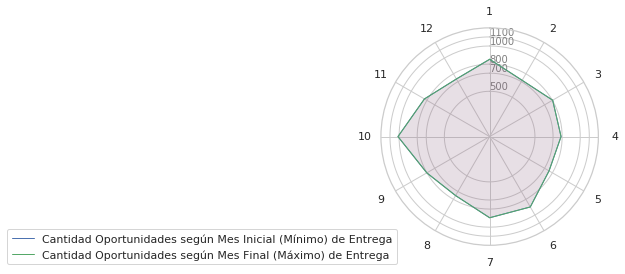

In [34]:
#number of variable
N = len(categories)
    
from math import pi
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)


# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([1100,1000,800, 700, 500], ["1100","1000","800","700","500","1200"], color="grey", size=10)
plt.ylim(0,1200)

values2 = list(opportunities.groupby('Planned_Delivery_Start_Date_Month')['Opportunity_ID'].count())
values2 += values2[:1]
ax.plot(angles, values2, linewidth=1, linestyle='solid', label="Cantidad Oportunidades según Mes Inicial (Mínimo) de Entrega")
ax.fill(angles, values2, 'b', alpha=0.1)



    
values = list(opportunities.groupby('Planned_Delivery_Start_Date_Month')['Opportunity_ID'].count())
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid',color = "C2", label="Cantidad Oportunidades según Mes Final (Máximo) de Entrega")
ax.fill(angles, values, 'r', alpha=0.1)



plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

--------------

In [35]:
#Duracion de las oportunidades
df_duracion = eci[['Opportunity_ID','Opportunity_Name','Planned_Delivery_Start_Date','Planned_Delivery_End_Date','Delivery_Quarter','Total_Amount','Territory','Stage']]
df_duracion.loc[df_duracion['Opportunity_ID'] == 12801]

,Opportunity_ID,Opportunity_Name,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Delivery_Quarter,Total_Amount,Territory,Stage
16942,12801,Opportunity_Name_9245,2016-03-21,2016-03-25,Q1,"103,350.00",Austria,Closed Won
16943,12801,Opportunity_Name_9245,2016-04-04,2016-04-08,Q2,"93,015.00",Austria,Closed Won
16944,12801,Opportunity_Name_9245,2016-03-28,2016-03-31,Q1,"103,350.00",Austria,Closed Won


In [36]:
#para la misma id_opportunity se ven diferentes fechas de comienzo y fin, 
#agrupo por id y me quedo con la fecha de comienzo mas chica y de fin mas grande como para calcular de la oportundad entera...
df_duracion_grouped = df_duracion.groupby('Opportunity_ID')\
    .agg({'Planned_Delivery_Start_Date':'min', 'Planned_Delivery_End_Date': 'max','Total_Amount':'sum', 'Territory':'first'})\
    .reset_index()
df_duracion_grouped.head(3)

,Opportunity_ID,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Total_Amount,Territory
0,0,2016-05-01,2016-06-30,"5,272,800.00",None
1,1,2016-01-18,2016-01-20,"48,230.00",None
2,2,2016-01-25,2016-01-25,"83,865.60",NW America


In [37]:
#calculo la duracion del proyecto en dias
df_duracion_grouped['Opportunity_duration'] = df_duracion_grouped['Planned_Delivery_End_Date'] - df_duracion_grouped['Planned_Delivery_Start_Date']
#agrego la duracion en meses y redondeo hacia arriba
df_duracion_grouped['Opportunity_duration_months'] = ((df_duracion_grouped['Planned_Delivery_End_Date'] - df_duracion_grouped['Planned_Delivery_Start_Date'])/np.timedelta64(1, 'M'))
df_duracion_grouped['Opportunity_duration_months'] = np.ceil(df_duracion_grouped['Opportunity_duration_months'])
#los diez proyectos de ventas mas largos
df_duracion_grouped.nlargest(10,'Opportunity_duration')

,Opportunity_ID,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Total_Amount,Territory,Opportunity_duration,Opportunity_duration_months
8914,9773,2018-10-14,2208-12-31,"290,713.50",Netherlands,69474 days,"2,283.00"
4114,4283,2017-08-01,2020-08-07,"1,887,900.00",NW America,1102 days,37.00
3936,4096,2017-07-10,2019-07-10,"5,702,850.00",NE America,730 days,24.00
4835,5026,2019-01-07,2020-06-30,"35,105,000.00",Kazakhstan,540 days,18.00
3721,3869,2016-12-01,2018-04-30,"16,983,000.00",Vietnam,515 days,17.00
5062,5263,2018-02-05,2019-06-28,"9,808,074.00",NE America,508 days,17.00
1833,1919,2017-04-01,2018-06-30,"9,151,720.20",NW America,455 days,15.00
2434,2536,2017-01-02,2018-03-30,"16,314,480.00",NE America,452 days,15.00
1042,1112,2016-03-07,2017-05-01,"4,893,277.50",NE America,420 days,14.00
2448,2551,2016-11-08,2017-12-28,"759,000.00",Netherlands,415 days,14.00


In [38]:
#se ve que la fecha de esta oportunidad no tiene sentido... elimino este registro
indexNames = df_duracion_grouped[df_duracion_grouped['Opportunity_ID'] == 9773].index
df_duracion_grouped.drop(indexNames , inplace=True)

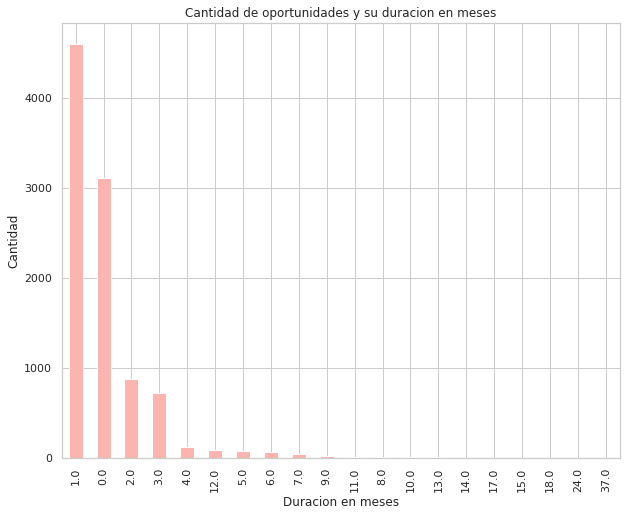

In [39]:
df_duracion_grouped['Opportunity_duration_months'].value_counts()\
    .plot.bar(colormap='Pastel1', title='Cantidad de oportunidades y su duracion en meses',figsize=(10,8))

plt.ylabel('Cantidad')
plt.xlabel('Duracion en meses')

plt.show()

---

In [40]:
stage = eciOp['Stage'].value_counts().to_frame().reset_index()\
                      .rename(columns={'index':'Stage','Stage':'cantidad'})
stage

,Stage,cantidad
0,Closed Won,5072
1,Closed Lost,4719
2,Proposal,30
3,Negotiation,11
4,Qualification,9


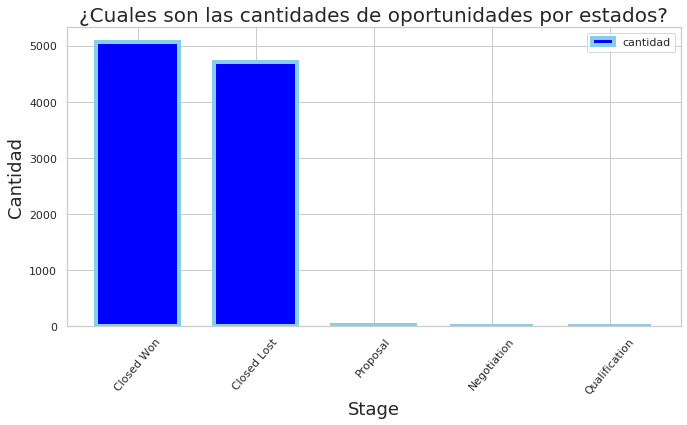

In [41]:
stage.plot(kind='bar', x='Stage', y='cantidad',\
                 width=0.7, figsize=(11,5.5), color='blue',\
                 edgecolor="skyblue", linewidth=4, rot=50)
g=plt.gca()
g.set_title("¿Cuales son las cantidades de oportunidades por estados?",\
            fontsize=20);
g.set_xlabel("Stage", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

-----------

Text(0.5, 0, 'Estado')

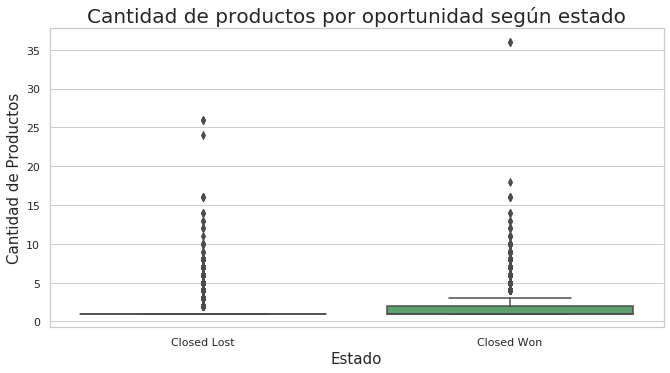

In [42]:
plt.figure(figsize=(11,5.5))

visua=sns.boxplot(x="Stage", y="Cantidad_de_Productos_por_Oportunidad", palette=["m", "g"], data=eciOp[(eciOp.Stage=='Closed Lost')|(eciOp.Stage=='Closed Won')])
visua.set_title("Cantidad de productos por oportunidad según estado", fontsize=20)
visua.set_ylabel("Cantidad de Productos" , fontsize=15)
visua.set_xlabel("Estado", fontsize=15)

---

In [43]:
opportunities['Territory'] = opportunities['Territory'].replace(to_replace='None', value=np.nan).dropna()

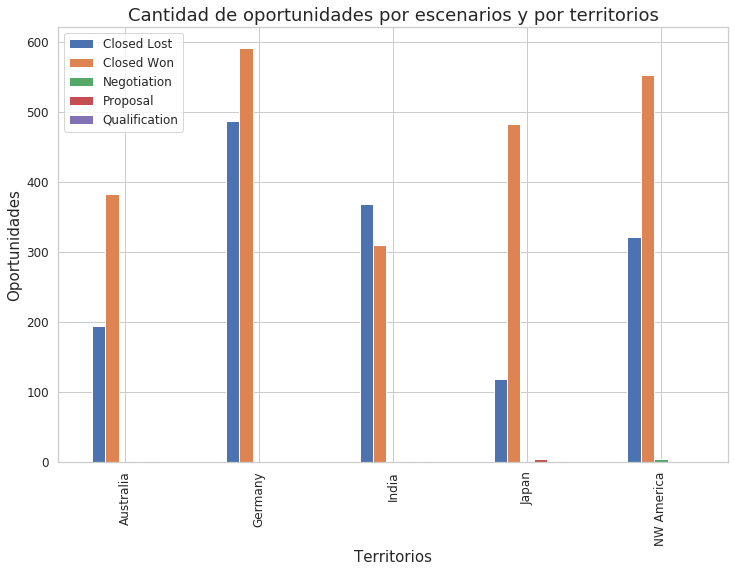

In [44]:
#obtenemos las 5 areas con mas avisos, no se si esto esta bien me tira el mismo resultado que con el groupby, usado por Martin
top_territories = opportunities['Territory'].value_counts().sort_values(ascending=False).head(5).keys().tolist()

df_top_stages = opportunities.loc[opportunities['Territory'].isin(top_territories)]\
    .groupby(['Territory','Stage']).agg({'Territory':'count'})\
    .rename(columns = {'Territory':'cant_oportunidades'})
    
axs = df_top_stages.reset_index().pivot(index = 'Territory', columns = 'Stage', values='cant_oportunidades')\
    .plot(kind = 'bar', figsize =(12,8), fontsize = 12\
          ,title ='Cantidad de oportunidades por escenarios y por territorios')
axs.set_ylabel('Oportunidades', size = 15)
axs.set_xlabel('Territorios', size = 15)
axs.legend(fontsize = 12)
axs.title.set_size(18)

---

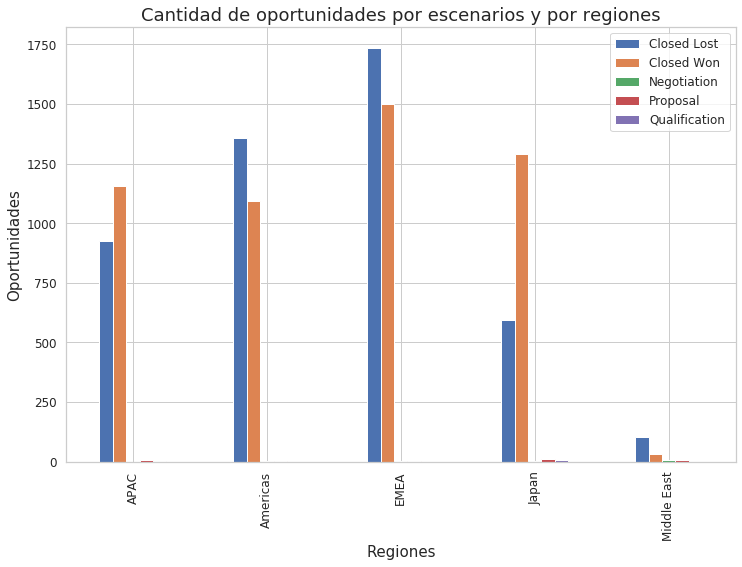

In [45]:
#obtenemos las 5 areas con mas avisos, no se si esto esta bien me tira el mismo resultado que con el groupby, usado por Martin
top_regions = opportunities['Region'].value_counts().sort_values(ascending=False).head(7).keys().tolist()

df_top_stages = opportunities.loc[opportunities['Region'].isin(top_regions)]\
    .groupby(['Region','Stage']).agg({'Region':'count'})\
    .rename(columns = {'Region':'cant_oportunidades'})
    
axs = df_top_stages.reset_index().pivot(index = 'Region', columns = 'Stage', values='cant_oportunidades')\
    .plot(kind = 'bar', figsize =(12,8), fontsize = 12\
          ,title ='Cantidad de oportunidades por escenarios y por regiones')
axs.set_ylabel('Oportunidades', size = 15)
axs.set_xlabel('Regiones', size = 15)
axs.legend(fontsize = 12)
axs.title.set_size(18)

---

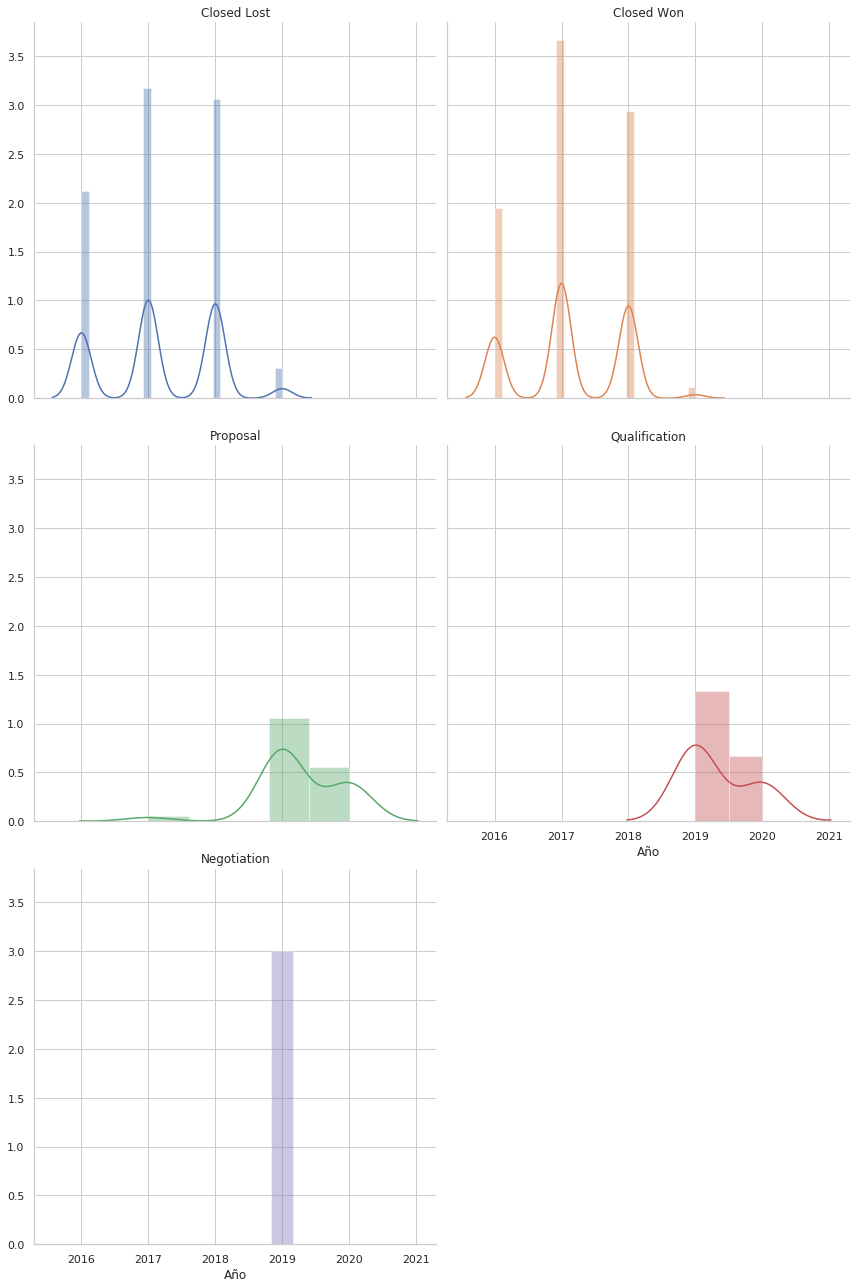

In [46]:
niveles = opportunities['Stage'].unique()
colores = sns.color_palette("hls", len(niveles))
hues = {}
for i, n in enumerate(niveles):
    hues[n] = colores
    
g = sns.FacetGrid(opportunities, col="Stage", hue="Stage", col_wrap=2, size=6)
g.map(sns.distplot, "Delivery_Year")
g.set_titles("{col_name}")
g.set_axis_labels("Año")

# 4. Monto gravado

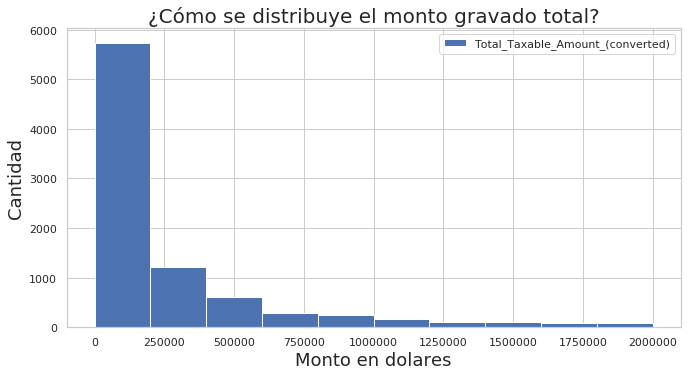

In [47]:
#Con el limite que puse en el rango se ve mejor, aunque no estoy teniendo en cuenta los valores mas grandes
#que se hacen cada vez mas chicos
eciOp[['Total_Taxable_Amount_(converted)']].plot(kind='hist',figsize=(11,5.5),range=[0,2000000])
g=plt.gca()
g.set_title("¿Cómo se distribuye el monto gravado total?",fontsize=20);
g.set_xlabel("Monto en dolares", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

-----------

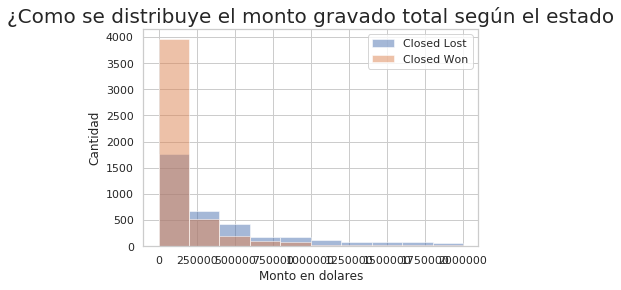

In [48]:
pyplot.hist(eciOp[eciOp.Stage=='Closed Lost']['Total_Taxable_Amount_(converted)'], alpha=0.5, label='Closed Lost',range=[0,2000000])
pyplot.hist(eciOp[eciOp.Stage=='Closed Won']['Total_Taxable_Amount_(converted)'], alpha=0.5, label='Closed Won',range=[0,2000000])
pyplot.title("¿Como se distribuye el monto gravado total según el estado", fontsize=20)
pyplot.ylabel('Cantidad')
pyplot.xlabel('Monto en dolares')
pyplot.legend()

---

In [49]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [50]:
df = eci
df['Territory'] = df['Territory'].replace(to_replace='None', value=np.nan).dropna()
df['Territory'] = df['Territory'].replace({'UAE (Dubai)': 'United Arab Emirates', 'China (PRC)': 'China', \
            'Czech Republic': 'Czechia', 'Solomon Islands': 'Solomon Is.', \
            'Bosnia & Herzegovina': 'Bosnia and Herz.', 'Central US': 'United States of America', \
            'Burma': 'Myanmar', 'KSA': 'Saudi Arabia'})

In [51]:
territory_amount = df.groupby('Territory').agg({'Total_Taxable_Amount_(converted)':'mean'})
territory_amount = territory_amount.rename(columns = {'Total_Taxable_Amount_(converted)': 'Mean_Total_Amount'})
territory_amount

,Mean_Total_Amount
Territory,
Albania,"2,183,479.33"
Armenia,"21,936,890.53"
Australia,"4,615,452.53"
Austria,"324,452.77"
Belarus,"5,902,739.00"
...,...
Ukraine,"3,854,279.13"
United Arab Emirates,"5,811,978.26"
United Kingdom,"2,080,349.18"


In [52]:
world_amount = world.set_index('name').join(territory_amount)

In [53]:
world_amount.sort_values('Mean_Total_Amount', ascending=False).head(5)

,pop_est,continent,iso_a3,gdp_md_est,geometry,Mean_Total_Amount
name,,,,,,
Kazakhstan,18556698,Asia,KAZ,"460,700.00","POLYGON ((87.35997 49.21498, 86.59878 48.54918...","42,306,219.32"
Romania,21529967,Europe,ROU,"441,000.00","POLYGON ((28.23355 45.48828, 28.67978 45.30403...","36,668,994.90"
Armenia,3045191,Asia,ARM,"26,300.00","POLYGON ((46.50572 38.77061, 46.14362 38.74120...","21,936,890.53"
Turkey,80845215,Asia,TUR,"1,670,000.00","MULTIPOLYGON (((44.77268 37.17044, 44.29345 37...","10,082,312.07"
Solomon Is.,647581,Oceania,SLB,"1,198.00","MULTIPOLYGON (((162.11902 -10.48272, 162.39865...","8,467,149.60"


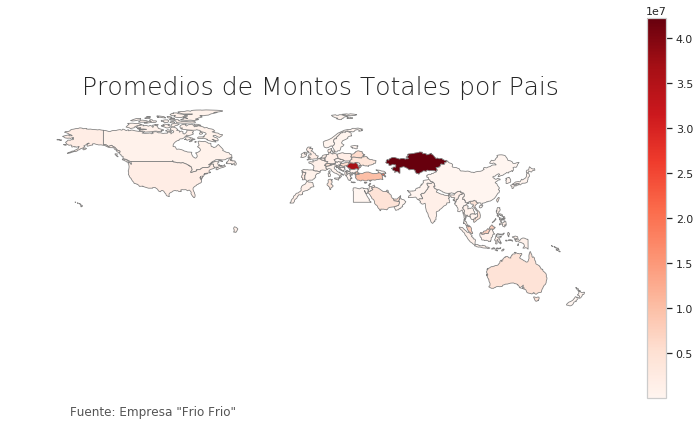

In [54]:
vmin, vmax = world_amount.Mean_Total_Amount.min(), world_amount.Mean_Total_Amount.max()

fig, ax = plt.subplots(1, figsize=(13, 7))

world_amount.plot(column='Mean_Total_Amount', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.5')
ax.axis('off')

ax.set_title('Promedios de Montos Totales por Pais', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Fuente: Empresa "Frio Frio"',xy=(0.1, .08),  xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
            
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

fig.show()

# 5. TRF

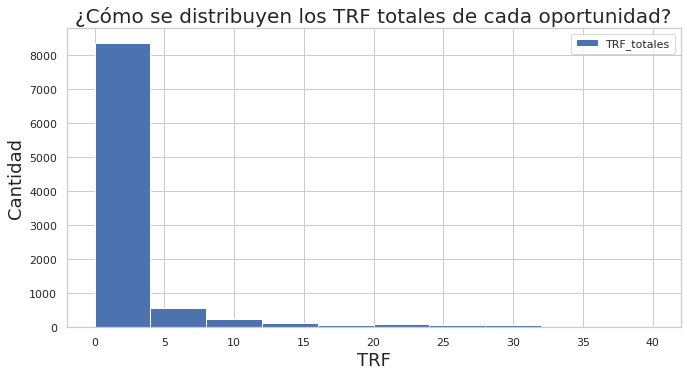

In [55]:
#Con el limite que puse en el rango se ve mejor, aunque no estoy teniendo en cuenta los valores mas grandes
#que se hacen cada vez mas chicos
eciOp[['TRF_totales']].plot(kind='hist',figsize=(11,5.5),range=[0,40])
g=plt.gca()
g.set_title("¿Cómo se distribuyen los TRF totales de cada oportunidad?",fontsize=20);
g.set_xlabel("TRF", fontsize=18);
g.set_ylabel("Cantidad", fontsize=18);

---

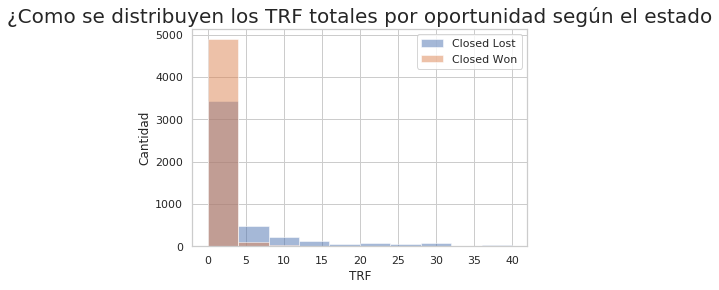

In [56]:
pyplot.hist(eciOp[eciOp.Stage=='Closed Lost']['TRF_totales'], alpha=0.5, label='Closed Lost',range=[0,40])
pyplot.hist(eciOp[eciOp.Stage=='Closed Won']['TRF_totales'], alpha=0.5, label='Closed Won',range=[0,40])
pyplot.title("¿Como se distribuyen los TRF totales por oportunidad según el estado", fontsize=20)
pyplot.ylabel('Cantidad')
pyplot.xlabel('TRF')
pyplot.legend()

---

In [57]:
TRF_promedio = eciOp.groupby('Stage').agg({'TRF_promedioDeLaOportunidad':'mean'}).reset_index()
TRF_promedio

,Stage,TRF_promedioDeLaOportunidad
0,Closed Lost,5.79
1,Closed Won,0.35
2,Negotiation,1.14
3,Proposal,4.68
4,Qualification,3.00


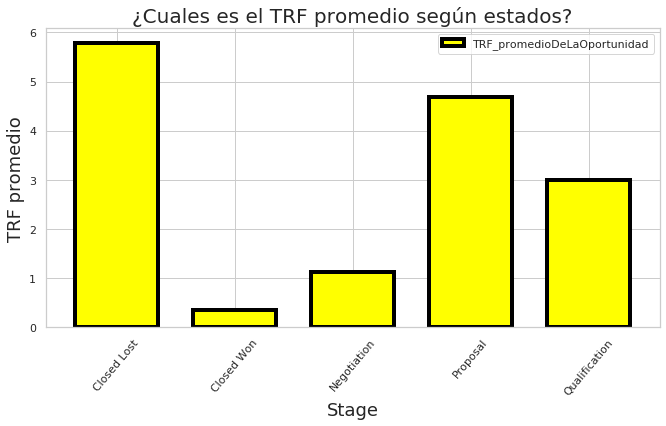

In [58]:
TRF_promedio.plot(kind='bar', x='Stage', y='TRF_promedioDeLaOportunidad',\
                 width=0.7, figsize=(11,5.5), color='yellow',\
                 edgecolor="black", linewidth=4, rot=50)
g=plt.gca()
g.set_title("¿Cuales es el TRF promedio según estados?",\
            fontsize=20);
g.set_xlabel("Stage", fontsize=18);
g.set_ylabel("TRF promedio", fontsize=18);

---

In [59]:
territory_TRF = df.groupby('Territory').agg({'TRF':'mean'})
territory_TRF = territory_TRF.rename(columns = {'TRF': 'Mean_TRF'})
territory_TRF

,Mean_TRF
Territory,
Albania,5.00
Armenia,27.50
Australia,5.68
Austria,0.18
Belarus,12.50
...,...
Ukraine,9.40
United Arab Emirates,11.84
United Kingdom,2.52


In [60]:
world_TRF = world.set_index('name').join(territory_TRF)
world_TRF

,pop_est,continent,iso_a3,gdp_md_est,geometry,Mean_TRF
name,,,,,,
Fiji,920938,Oceania,FJI,"8,374.00","MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",nan
Tanzania,53950935,Africa,TZA,"150,600.00","POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",nan
W. Sahara,603253,Africa,ESH,906.50,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",nan
Canada,35623680,North America,CAN,"1,674,000.00","MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1.27
United States of America,326625791,North America,USA,"18,560,000.00","MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",1.80
...,...,...,...,...,...,...
Serbia,7111024,Europe,SRB,"101,800.00","POLYGON ((18.82982 45.90887, 18.82984 45.90888...",nan
Montenegro,642550,Europe,MNE,"10,610.00","POLYGON ((20.07070 42.58863, 19.80161 42.50009...",nan
Kosovo,1895250,Europe,-99,"18,490.00","POLYGON ((20.59025 41.85541, 20.52295 42.21787...",3.50


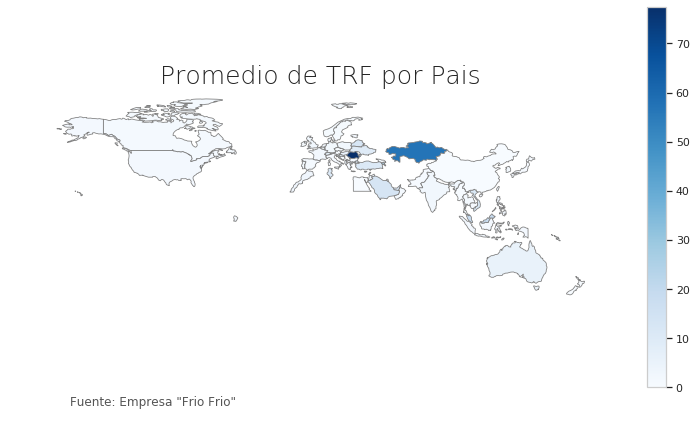

In [61]:
vmin, vmax = world_TRF.Mean_TRF.min(), world_TRF.Mean_TRF.max()

fig, ax = plt.subplots(1, figsize=(13, 7))

world_TRF.plot(column='Mean_TRF', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.5')
ax.axis('off')

ax.set_title('Promedio de TRF por Pais', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Fuente: Empresa "Frio Frio"',xy=(0.1, .08),  xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
            
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

fig.show()

---

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


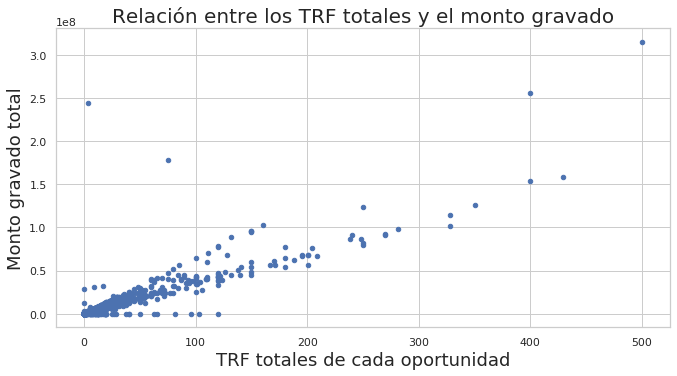

In [62]:
eciOp.plot(kind='scatter', x='TRF_totales', y='Total_Taxable_Amount_(converted)',figsize=(11,5.5))
g=plt.gca()
g.set_title("Relación entre los TRF totales y el monto gravado",\
            fontsize=20);
g.set_xlabel("TRF totales de cada oportunidad", fontsize=18);
g.set_ylabel("Monto gravado total", fontsize=18);

# 6. Porcentaje de oportunidades ganadas

In [63]:
regionGroup = eciWon.groupby(['Region']).agg({'ganada':['sum','count']}).reset_index()
regionGroup.columns = ['Region','cantidad de won','total']
regionGroup

,Region,cantidad de won,total
0,APAC,1155,2079
1,Americas,1094,2452
2,EMEA,1500,3237
3,Japan,1290,1885
4,Middle East,33,138


In [64]:
regionGroup['porcentaje de oportunidades ganadas'] = regionGroup['cantidad de won']/regionGroup['total']*100
regionGroup.sort_values('porcentaje de oportunidades ganadas',ascending=False,inplace=True)

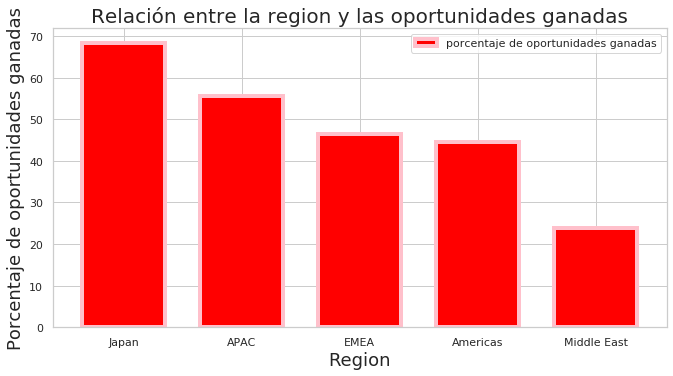

In [65]:
regionGroup.plot(kind='bar', x='Region', y='porcentaje de oportunidades ganadas',\
                 width=0.7, figsize=(11,5.5), color='red',\
                 edgecolor="pink", linewidth=4,rot=0)
g=plt.gca()
g.set_title("Relación entre la region y las oportunidades ganadas",\
            fontsize=20);
g.set_xlabel("Region", fontsize=18);
g.set_ylabel("Porcentaje de oportunidades ganadas", fontsize=18);

---

In [66]:
eciWon['Territory'] = eciWon['Territory'].apply(lambda x: cambiar_nombre(x))

In [67]:
territoryGroup = eciWon.groupby(['Territory']).agg({'ganada':['sum','count']}).reset_index()
territoryGroup.columns = ['Territory','cantidad de won','total']
territoryGroup

,Territory,cantidad de won,total
0,Albania,0,2
1,Armenia,0,1
2,Australia,383,577
3,Austria,58,72
4,Belarus,0,3
...,...,...,...
65,Ukraine,0,4
66,United Arab Emirates,2,28
67,United Kingdom,89,228
68,United States,928,1978


In [68]:
#Sacamos los territorios que aparcen muy pocas veces para no caer en "la ecuacion mas peligrosa de la historia"
territoryGroup = territoryGroup[territoryGroup['total']>10]

In [69]:
territoryGroup['Porcentaje de oportunidades ganadas'] = territoryGroup['cantidad de won']/territoryGroup['total']*100
territoryGroup.sort_values('Porcentaje de oportunidades ganadas',ascending=False,inplace=True)

In [70]:
territoryGroup['Code'] = territoryGroup['Territory'].apply(lambda x: get_alpha_3(x))

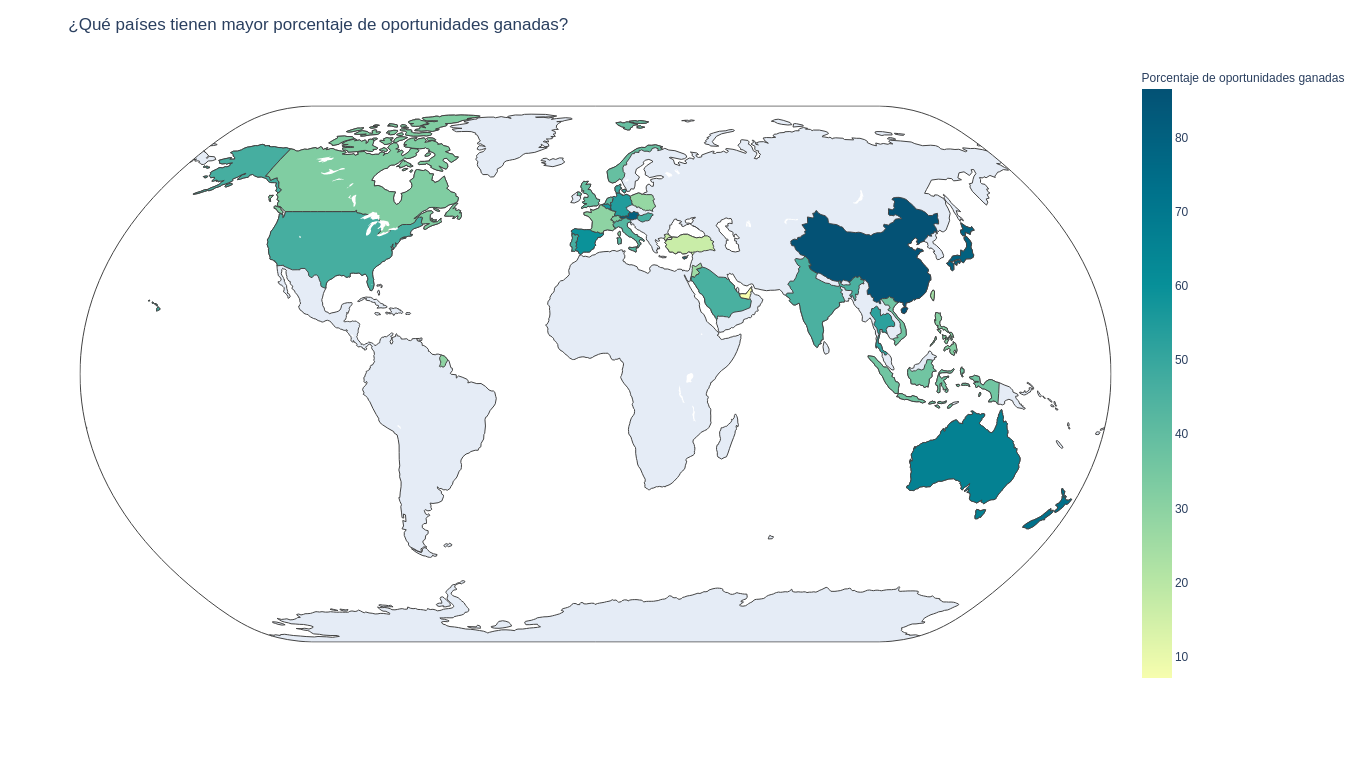

In [71]:
fig = px.choropleth(territoryGroup,locations='Code',color='Porcentaje de oportunidades ganadas',\
                    color_continuous_scale=px.colors.sequential.Bluyl,hover_name='Territory',)
fig.update_layout(
    title_text = '¿Qué países tienen mayor porcentaje de oportunidades ganadas?'
)
fig.update_geos(projection_type="natural earth")
#fig.show()
fig.write_image("visu.png",width=1366,height= 768)
Image("visu.png")

---

In [72]:
buro = eciWon.groupby(['Bureaucratic_Code']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
buro.columns = ['Codigo burocratico','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
buro['Monto Reescalado'] = buro['Monto gravado total'].apply(lambda x: x*0.00001)
buro['Porcentaje de ganadas'] = (buro['Cantidad de ganadas']/buro['Total de Oportunidades'])*100
#Sacamos los codigos que aparcen muy pocas veces para no caer en "la ecuacion mas peligrosa de la historia"
buro = buro[buro['Total de Oportunidades']>2]
buro

,Codigo burocratico,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
0,Bureaucratic_Code_0,11,11,"88,022,623.74",40,880.23,100.00
1,Bureaucratic_Code_1,58,177,"153,081,156.29",0,"1,530.81",32.77
2,Bureaucratic_Code_2,34,120,"576,405,272.08",1,"5,764.05",28.33
4,Bureaucratic_Code_4,4408,7400,"7,955,583,525.39",10,"79,555.84",59.57
5,Bureaucratic_Code_5,559,2080,"8,202,104,544.33",14,"82,021.05",26.88


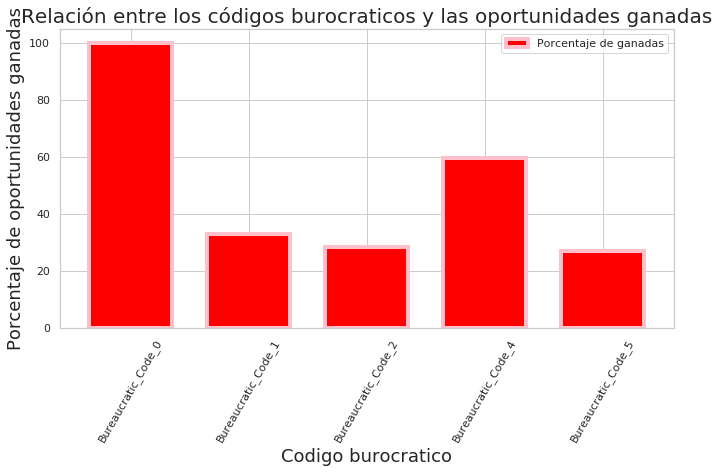

In [73]:
buro.plot(kind='bar', x='Codigo burocratico', y='Porcentaje de ganadas',\
                 width=0.7, figsize=(11,5.5), color='red',\
                 edgecolor="pink", linewidth=4,rot=60)
g=plt.gca()
g.set_title("Relación entre los códigos burocraticos y las oportunidades ganadas",\
            fontsize=20);
g.set_xlabel("Codigo burocratico", fontsize=18);
g.set_ylabel("Porcentaje de oportunidades ganadas", fontsize=18);

# 7. Códigos burocraticos y aprobaciones epeciales

In [74]:
necesitaAprobacion = eciOp['Pricing, Delivery_Terms_Quote_Appr'].value_counts()[1]
obtuvoAprobacion = eciOp['Pricing, Delivery_Terms_Approved'].value_counts()[1]

Text(0, 0.5, 'Cantidad de oportunidades')

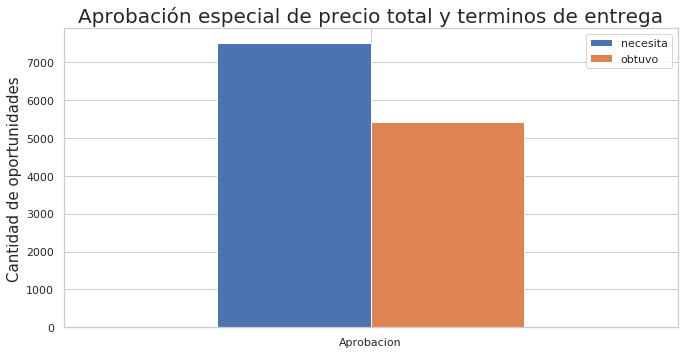

In [75]:
index = ['Aprobacion']
df = pd.DataFrame({'necesita': necesitaAprobacion,'obtuvo': obtuvoAprobacion}, index=index)
ax = df.plot.bar(rot=0,figsize=(11,5.5))
ax.set_title("Aprobación especial de precio total y terminos de entrega", fontsize=20)
ax.set_ylabel("Cantidad de oportunidades" , fontsize=15)

---

In [76]:
necesitaCodigo = eciOp['Bureaucratic_Code_0_Approval'].value_counts()[1]
obtuvoCodigo = eciOp['Bureaucratic_Code_0_Approved'].value_counts()[1]

Text(0, 0.5, 'Cantidad de oportunidades')

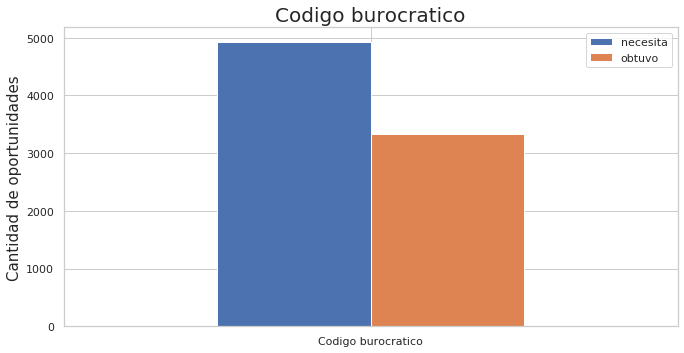

In [77]:
index = ['Codigo burocratico']
df = pd.DataFrame({'necesita': necesitaCodigo,'obtuvo': obtuvoCodigo}, index=index)
ax = df.plot.bar(rot=0,figsize=(11,5.5))
ax.set_title("Codigo burocratico", fontsize=20)
ax.set_ylabel("Cantidad de oportunidades" , fontsize=15)

---

In [78]:
bureauctratic_codes= eci.groupby(['Bureaucratic_Code_0_Approval','Bureaucratic_Code_0_Approved'])['Stage'].value_counts().to_frame()
bureauctratic_codes = bureauctratic_codes.unstack()
bureauctratic_codes.columns= ['Closed Lost','Closed Won','Negotiation', 'Proposal','Qualification']
bureauctratic_codes = bureauctratic_codes.reset_index()
bureauctratic_codes = bureauctratic_codes.fillna(0)
#0 si no se necesito ni aprobo
#1 si se necesito y aprobo
#2 si se necesito y no se aprobo
conditions = [
    ((bureauctratic_codes['Bureaucratic_Code_0_Approval']) == 0 & (bureauctratic_codes['Bureaucratic_Code_0_Approved'] == 0)),
    ((bureauctratic_codes['Bureaucratic_Code_0_Approval']) == 1 & (bureauctratic_codes['Bureaucratic_Code_0_Approved'] == 0)),
    ((bureauctratic_codes['Bureaucratic_Code_0_Approval']) == 1 & (bureauctratic_codes['Bureaucratic_Code_0_Approved'] == 1)),
    ]

# create a list of the values we want to assign for each condition
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
bureauctratic_codes['Bureauctratic_code'] = np.select(conditions, values)
bureauctratic_codes['Total_opportunities'] =  bureauctratic_codes['Closed Lost'] + bureauctratic_codes['Closed Won']\
+ bureauctratic_codes['Negotiation'] + bureauctratic_codes['Proposal'] + bureauctratic_codes['Qualification'] 
bureauctratic_codes

,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Closed Lost,Closed Won,Negotiation,Proposal,Qualification,Bureauctratic_code,Total_opportunities
0,0,0,"2,961.00","5,928.00",0.00,0.00,0.00,0,"8,889.00"
1,1,0,"1,846.00",787.00,1.00,9.00,11.00,1,"2,654.00"
2,1,1,"2,543.00","2,818.00",17.00,26.00,0.00,2,"5,404.00"


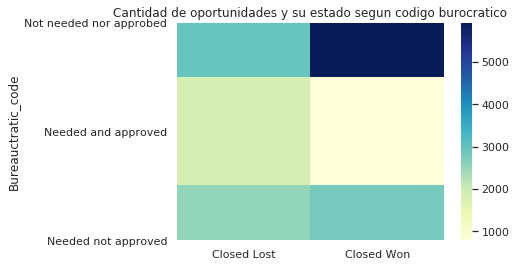

In [79]:
heatmap_data = bureauctratic_codes.set_index('Bureauctratic_code').loc[:,['Closed Lost','Closed Won']]
x_axis_labels = ['Closed Lost','Closed Won'] 
y_axis_labels = ['Not needed nor approbed','Needed and approved','Needed not approved'] 
ax = plt.axes()
sns.heatmap(heatmap_data, xticklabels=x_axis_labels, yticklabels=y_axis_labels,cmap="YlGnBu", ax = ax)
ax.set_title('Cantidad de oportunidades y su estado segun codigo burocratico')
plt.show()

---

In [81]:
df.head()

,necesita,obtuvo
Codigo burocratico,4933,3337


In [82]:
territories = eci['Territory'].value_counts().sort_values(ascending=False).head(10).keys().tolist()
territories

['Germany',
 'NW America',
 'Australia',
 'India',
 'NE America',
 'Japan',
 'Netherlands',
 'SE America',
 'France',
 'Singapore']

In [85]:
df_heatmap = eci.loc[eci['Territory'].isin(territories)]\
    .groupby(['Territory','Pricing, Delivery_Terms_Quote_Appr']).agg({'Territory':'count'})\
    .rename(columns = {'Territory':'cant_territory'})
df_heatmap.head()

cant_territory
Territory Pricing, Delivery_Terms_Quote_Appr                
Australia 0                                              332
          1                                              876
France    0                                              114
          1                                              335
Germany   0                                              384

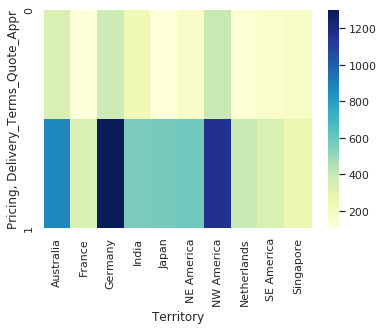

In [86]:
heatmap1_data = pd.pivot_table(df_heatmap, values='cant_territory', 
                     index=['Pricing, Delivery_Terms_Quote_Appr'], 
                     columns='Territory')

sns.heatmap(heatmap1_data, cmap="YlGnBu")

---

In [89]:
df_heatmap2 = eci.loc[eci['Territory'].isin(territories)]\
    .groupby(['Territory','Bureaucratic_Code_0_Approved']).agg({'Territory':'count'})\
    .rename(columns = {'Territory':'cant_territory'})
df_heatmap2.head()

cant_territory
Territory Bureaucratic_Code_0_Approved                
Australia 0                                        609
          1                                        599
France    0                                        308
          1                                        141
Germany   0                                       1078

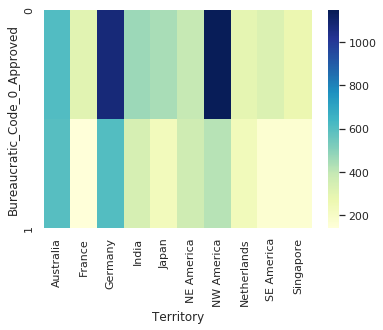

In [90]:
heatmap2_data = pd.pivot_table(df_heatmap2, values='cant_territory', 
                     index=['Bureaucratic_Code_0_Approved'], 
                     columns='Territory')

sns.heatmap(heatmap2_data, cmap="YlGnBu")

# 8. Vendedores

In [91]:
#vendedores y sus oporntunidades
vendedores = eci.groupby('Account_Owner')['Stage'].value_counts().to_frame()
vendedores =vendedores.unstack()
vendedores.columns = ['Closed Lost','Closed Won','Negotiation','Proposal','Qualification']
vendedores =vendedores.fillna(0)

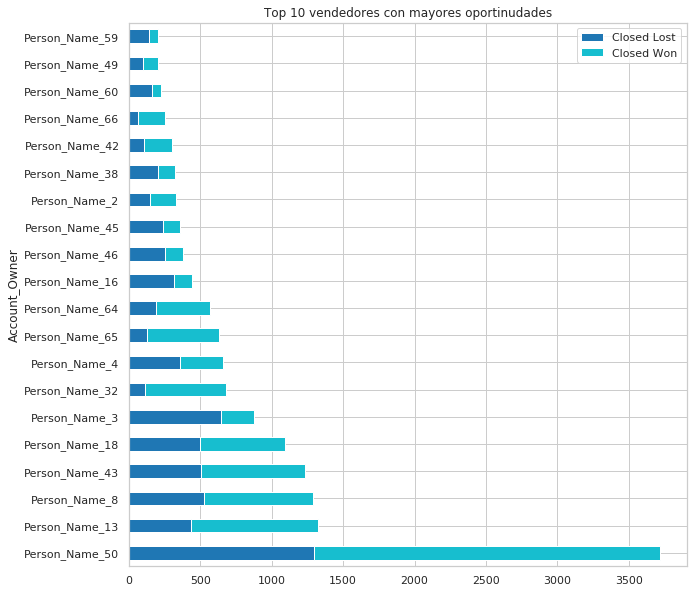

In [92]:
vendedores['Cantidad'] = vendedores['Closed Lost'] + vendedores['Closed Won'] + vendedores['Negotiation'] + vendedores['Proposal'] + vendedores['Qualification']
vendedores_top_10 = vendedores.nlargest(20,'Cantidad')
#vendedores_top_10[['Closed Lost','Closed Won','Negotiation','Proposal','Qualification']].plot.barh(stacked = True, colormap='Pastel1', title='Vendedores con mayores oportunidades', figsize=(10,10))
vendedores_top_10[['Closed Lost','Closed Won']].plot.barh(stacked = True, colormap='tab10', title='Top 10 vendedores con mayores oportinudades', figsize=(10,10))

In [93]:
#vendedores normalizado y sus oporntunidades
vendedores2 = eci.groupby('Account_Owner')['Stage'].value_counts(normalize = True).to_frame()
vendedores2 =vendedores2.unstack()
vendedores2.columns = ['Closed Lost','Closed Won','Negotiation','Proposal','Qualification']
vendedores2 =vendedores2.fillna(0)

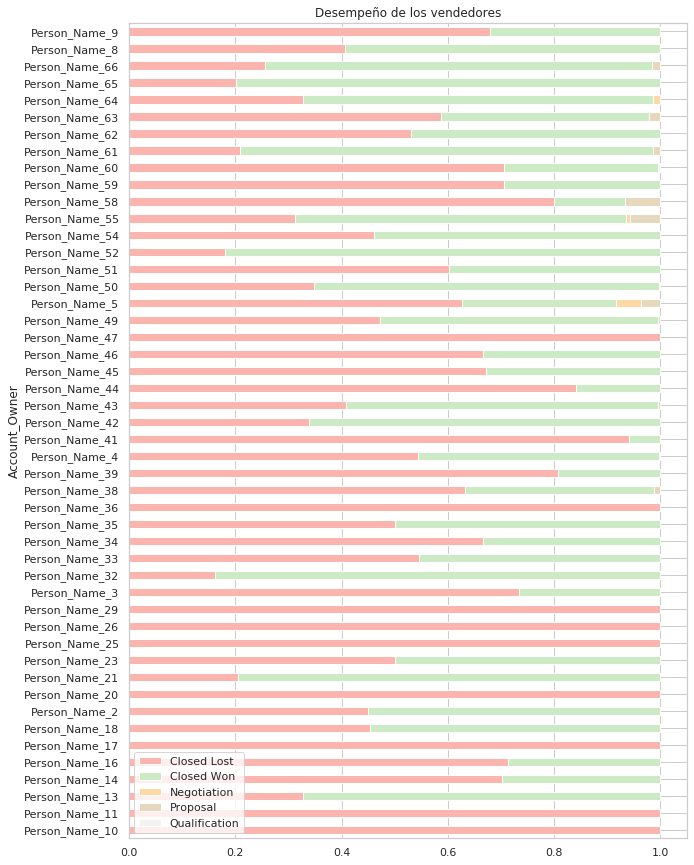

In [94]:
#vendedores normalizado, cuantas oportunidades cerraron, perdieron,...
vendedores2.plot.barh(stacked = True, colormap='Pastel1', title='Desempeño de los vendedores',figsize =(10,15))

# 9. Distribucion de oportunidades y monto

In [95]:
bubbleVendedores = eciWon.groupby(['Opportunity_Owner']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleVendedores.columns = ['Vendedor','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleVendedores['Monto Reescalado'] = bubbleVendedores['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleVendedores['Porcentaje de ganadas'] = (bubbleVendedores['Cantidad de ganadas']/bubbleVendedores['Total de Oportunidades'])*100
bubbleVendedores.head()

,Vendedor,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
0,Person_Name_0,0,1,"651,061.13",2,0.65,0.00
1,Person_Name_10,0,2,"32,912,058.32",1,32.91,0.00
2,Person_Name_11,26,71,"86,043,920.20",0,86.04,36.62
3,Person_Name_12,4,20,"873,557,641.15",0,873.56,20.00
4,Person_Name_13,434,756,"1,236,549,119.72",0,"1,236.55",57.41


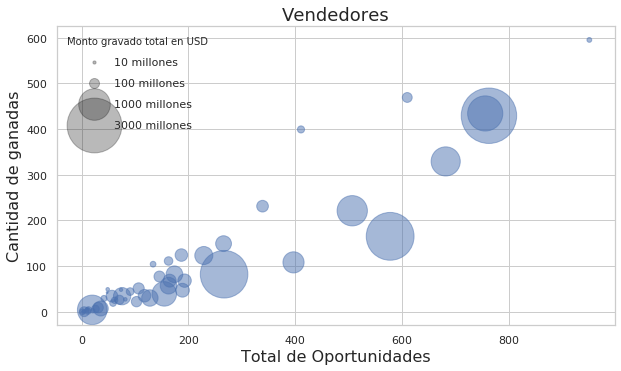

In [96]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleVendedores,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Vendedores", size=18)


for area in [10, 100, 1000, 3000]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

---

In [97]:
bubbleSource = eciWon.groupby(['Source ']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleSource.columns = ['Fuente de creacion de la oportunidad','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleSource['Monto Reescalado'] = bubbleSource['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleSource['Porcentaje de ganadas'] = (bubbleSource['Cantidad de ganadas']/bubbleSource['Total de Oportunidades'])*100
bubbleSource = bubbleSource[bubbleSource['Fuente de creacion de la oportunidad']!='None']
bubbleSource = bubbleSource[bubbleSource['Total de Oportunidades']>4]
bubbleSource

,Fuente de creacion de la oportunidad,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
2,Source_1,28,88,"302,422,601.18",2,302.42,31.82
3,Source_10,31,89,"98,600,853.83",1,98.60,34.83
4,Source_11,536,847,"1,250,039,359.75",14,"1,250.04",63.28
6,Source_13,374,533,"648,762,717.39",20,648.76,70.17
7,Source_2,26,68,"212,026,555.30",1,212.03,38.24
8,Source_3,159,302,"502,947,708.06",1,502.95,52.65
9,Source_4,16,32,"12,211,067.96",0,12.21,50.00
11,Source_6,5,17,"25,268,950.81",0,25.27,29.41
12,Source_7,908,2063,"4,921,689,697.21",0,"4,921.69",44.01
13,Source_9,486,871,"856,729,110.84",1,856.73,55.80


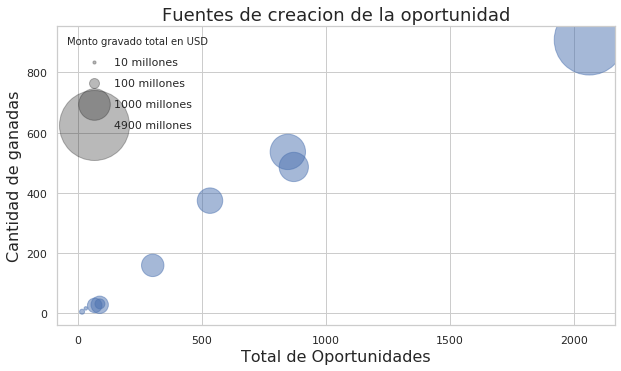

In [98]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleSource,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Fuentes de creacion de la oportunidad", size=18)


for area in [10, 100, 1000, 4900]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

---

In [99]:
bubbleAccount = eciWon.groupby(['Account_Name']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleAccount.columns = ['Cuentas de clientes','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleAccount['Monto Reescalado'] = bubbleAccount['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleAccount['Porcentaje de ganadas'] = (bubbleAccount['Cantidad de ganadas']/bubbleAccount['Total de Oportunidades'])*100
bubbleAccount = bubbleAccount[bubbleAccount['Total de Oportunidades']>35]
bubbleAccount.head()

,Cuentas de clientes,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
62,Account_Name_1067,47,94,"22,953,308.73",0,22.95,50.00
69,Account_Name_1075,67,83,"77,860,683.36",120,77.86,80.72
91,Account_Name_1100,23,45,"71,641,690.41",0,71.64,51.11
241,Account_Name_1274,61,77,"10,085,507.08",0,10.09,79.22
279,Account_Name_1313,49,68,"74,366,848.05",4,74.37,72.06


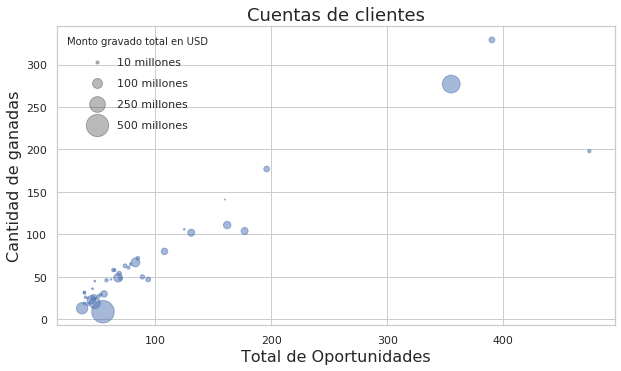

In [100]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleAccount,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Cuentas de clientes", size=18)


for area in [10, 100, 250, 500]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

---

In [101]:
bubbleAccountType = eciWon.groupby(['Account_Type']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleAccountType.columns = ['Tipo de cuenta cliente','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleAccountType['Monto Reescalado'] = bubbleAccountType['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleAccountType['Porcentaje de ganadas'] = (bubbleAccountType['Cantidad de ganadas']/bubbleAccountType['Total de Oportunidades'])*100
bubbleAccountType = bubbleAccountType[(bubbleAccountType['Total de Oportunidades']>17) & (bubbleAccountType['Tipo de cuenta cliente']!= 'None')]
bubbleAccountType

,Tipo de cuenta cliente,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
0,Account_Type_0,2332,3418,"1,460,419,236.69",0,"1,460.42",68.23
1,Account_Type_1,17,124,"1,171,374,915.52",1,"1,171.37",13.71
2,Account_Type_2,2282,4676,"7,330,780,267.19",10,"7,330.78",48.80
4,Account_Type_5,432,1445,"6,373,970,722.19",0,"6,373.97",29.90


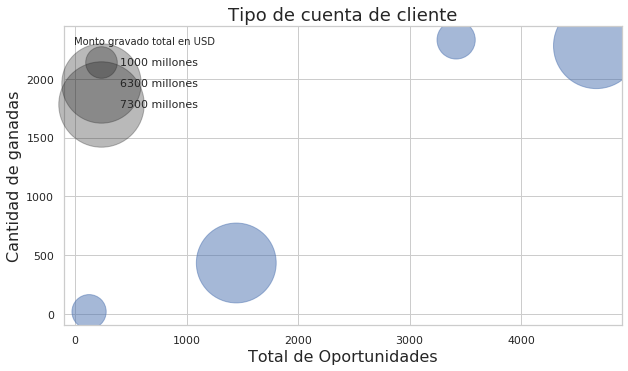

In [102]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleAccountType,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Tipo de cuenta de cliente", size=18)


for area in [1000, 6300, 7300]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

---

In [103]:
bubbleOpportunity = eciWon.groupby(['Opportunity_Type']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleOpportunity.columns = ['Tipo de oportunidad','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleOpportunity['Monto Reescalado'] = bubbleOpportunity['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleOpportunity['Porcentaje de ganadas'] = (bubbleOpportunity['Cantidad de ganadas']/bubbleOpportunity['Total de Oportunidades'])*100
bubbleOpportunity = bubbleOpportunity[bubbleOpportunity['Total de Oportunidades']>9]
bubbleOpportunity.head()

,Tipo de oportunidad,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
1,Opportunity_Type_1,2668,5128,"3,058,184,078.48",10,"3,058.18",52.03
2,Opportunity_Type_10,11,15,"2,239,493.39",0,2.24,73.33
4,Opportunity_Type_12,122,138,"34,133,962.40",0,34.13,88.41
6,Opportunity_Type_14,6,10,"720,554.95",0,0.72,60.00
10,Opportunity_Type_18,2,10,"38,703,671.00",68,38.70,20.00


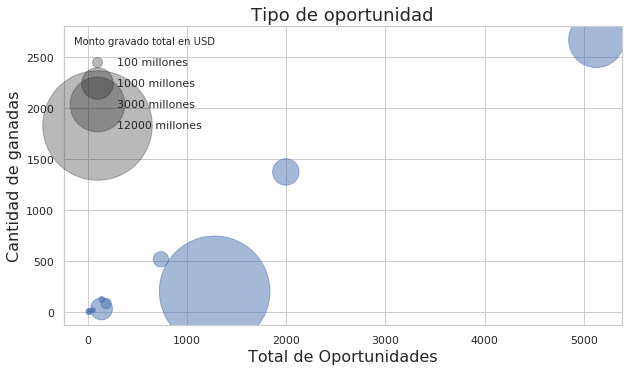

In [104]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleOpportunity,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Tipo de oportunidad", size=18)


for area in [100, 1000, 3000, 12000]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

---

In [105]:
bubbleDelivery = eciWon.groupby(['Delivery_Terms']).agg({'ganada':['sum','count'],'Total_Taxable_Amount_(converted)':'sum','TRF_totales':'first'}).reset_index()
bubbleDelivery.columns = ['Terminos de entrega','Cantidad de ganadas','Total de Oportunidades','Monto gravado total','TRF totales']
bubbleDelivery['Monto Reescalado'] = bubbleDelivery['Monto gravado total'].apply(lambda x: x*0.000001)
bubbleDelivery['Porcentaje de ganadas'] = (bubbleDelivery['Cantidad de ganadas']/bubbleDelivery['Total de Oportunidades'])*100
bubbleDelivery = bubbleDelivery[bubbleDelivery['Total de Oportunidades']>4]
bubbleDelivery

,Terminos de entrega,Cantidad de ganadas,Total de Oportunidades,Monto gravado total,TRF totales,Monto Reescalado,Porcentaje de ganadas
1,Delivery_Terms_1,893,1985,"5,210,583,911.92",14,"5,210.58",44.99
2,Delivery_Terms_2,1544,3218,"3,568,384,870.32",10,"3,568.38",47.98
3,Delivery_Terms_3,15,32,"58,013,994.03",3,58.01,46.88
4,Delivery_Terms_4,1885,3446,"7,069,266,099.84",0,"7,069.27",54.70
5,Delivery_Terms_5,348,522,"287,827,441.05",0,287.83,66.67
6,Delivery_Terms_6,301,434,"460,816,376.45",0,460.82,69.35
7,Delivery_Terms_7,19,36,"212,346,194.54",0,212.35,52.78
8,Delivery_Terms_8,65,114,"117,079,070.04",0,117.08,57.02


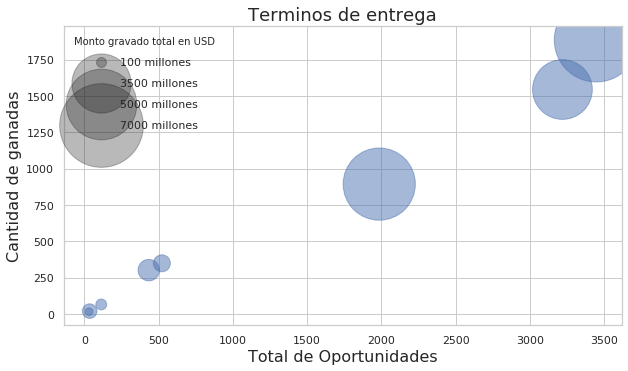

In [106]:
plt.figure(figsize=(10,5.5))
plt.scatter('Total de Oportunidades', 'Cantidad de ganadas', 
             s='Monto Reescalado',
             alpha=0.5, 
             data=bubbleDelivery,label=None)
plt.xlabel("Total de Oportunidades", size=16)
plt.ylabel("Cantidad de ganadas", size=16)
plt.title("Terminos de entrega", size=18)


for area in [100, 3500, 5000, 7000]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area) + ' millones')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Monto gravado total en USD')

# 10. Productos por etapa

In [107]:
productos = eci.groupby('Product_Name')['Stage'].value_counts().to_frame()
productos = productos.unstack()
productos.columns = ['Closed Lost','Closed Won','Negotiation','Proposal','Qualification']
productos = productos.fillna(0).nlargest(20, 'Closed Won')

Text(0, 0.5, 'Productos')

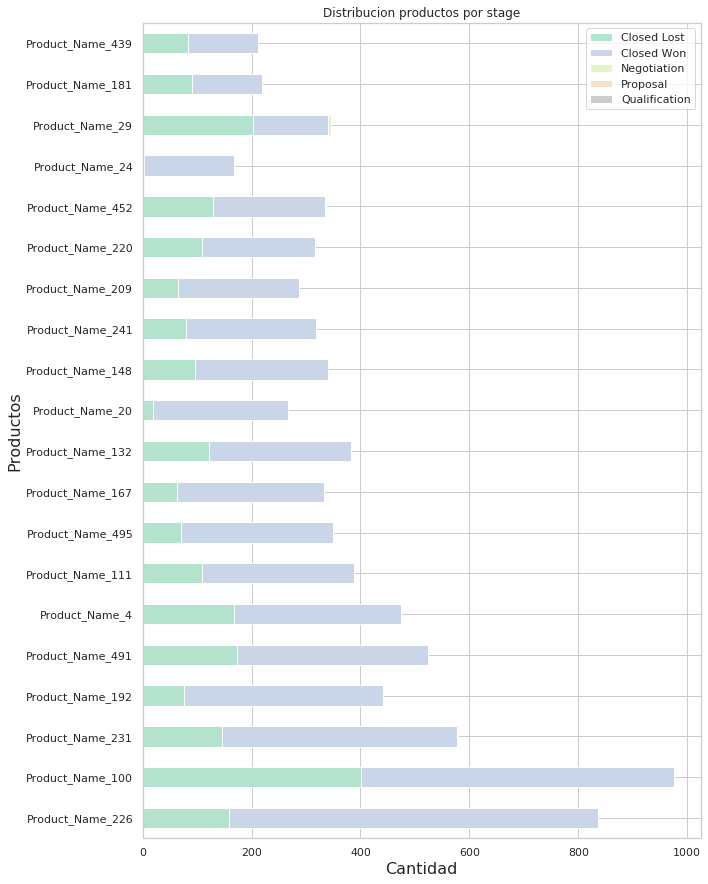

In [108]:
productos.plot.barh(stacked = True, colormap='Pastel2', title='Distribucion productos por stage',figsize =(10,15))
plt.xlabel("Cantidad", size=16)
plt.ylabel("Productos", size=16)

In [109]:
productosYear = eci.groupby('Product_Name')['Delivery_Year'].value_counts().to_frame()
productosYear = productosYear.unstack()
productosYear.columns = ['2016','2017','2018','2019','2020']
productosYear = productosYear.fillna(0).nlargest(20,'2019')

Text(0, 0.5, 'Productos')

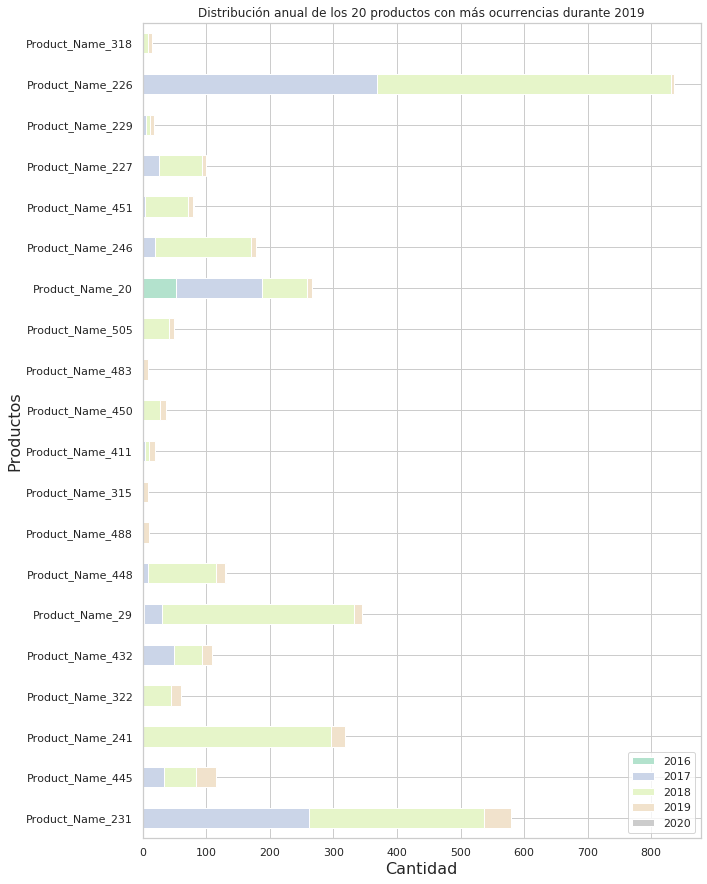

In [110]:
productosYear.plot.barh(stacked = True, colormap='Pastel2', title='Distribución anual de los 20 productos con más ocurrencias durante 2019',figsize =(10,15))
plt.xlabel("Cantidad", size=16)
plt.ylabel("Productos", size=16)

# 10. Marca

In [10]:
df = eci.dropna()

In [11]:
df_brand = df.groupby('Brand').agg(cant_onwer = ('Opportunity_Owner','count'))

In [12]:
df_brand = df_brand.reset_index()

In [13]:
top_10_brands = df_brand.sort_values('cant_onwer', ascending=False).head(10)

In [14]:
top_10_brands

,Brand,cant_onwer
24,None,12633
25,Other,571
23,Brand_9,136
20,Brand_5,43
14,Brand_24,38
3,Brand_11,32
2,Brand_10,22
12,Brand_22,20
15,Brand_25,19
5,Brand_13,17


In [15]:
# number of variable
categories = list(top_10_brands.groupby('Brand').count().index)
#categories = [2016,2017,2018,2019,2020]
print(categories)

['Brand_10', 'Brand_11', 'Brand_13', 'Brand_22', 'Brand_24', 'Brand_25', 'Brand_5', 'Brand_9', 'None', 'Other']


In [16]:
categories.remove('None')
categories.remove('Other')

In [17]:
print(categories)

['Brand_10', 'Brand_11', 'Brand_13', 'Brand_22', 'Brand_24', 'Brand_25', 'Brand_5', 'Brand_9']


In [18]:
cant_onwers = top_10_brands['cant_onwer'].tolist()

In [19]:
print(cant_onwers)

[12633, 571, 136, 43, 38, 32, 22, 20, 19, 17]


In [20]:
cant_onwers.remove(12633)
cant_onwers.remove(571)

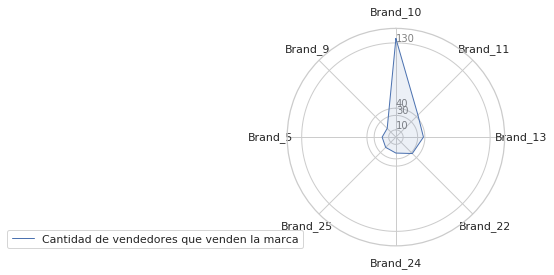

In [21]:
# number of variable
N = len(categories)
    
    
from math import pi
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)


# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([130,40, 30, 10], ["130","40","30", "10", "150"], color="grey", size=10)
plt.ylim(0,150)

values2 = list(cant_onwers)
values2 += values2[:1]

ax.plot(angles, values2, linewidth=1, linestyle='solid', label="Cantidad de vendedores que venden la marca")
ax.fill(angles, values2, 'b', alpha=0.1)


plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
